In [1]:
import autograd.numpy as np
from autograd import jacobian

# Define the vector-valued function x(q)
def x(q):
    r = q[0]
    theta = q[1]
    phi = q[2]
    x1 = r*np.sin(theta)*np.cos(phi)
    x2 = r*np.sin(theta)*np.sin(phi)
    x3 = r*np.cos(theta)
    return np.array([x1, x2, x3])

# Calculate the derivative of x(q) using autograd
J = jacobian(x)

print("Derivative of x(q) with respect to q:")
q = np.array([2., np.pi*0.5, np.pi*1.15])
#q[1] = np.pi*0
G = J(q).T @ J(q)
g = np.sqrt(np.linalg.det(G))
print(g)

Derivative of x(q) with respect to q:
3.9999999999999996


In [2]:
class PointMass(np.ndarray):
    def __new__(cls, position, mass = 1.):
        obj = np.asarray(position).view(cls)
        obj = obj.reshape((-1, 3))
        obj.mass = mass
        return obj
    
    def mass_weighted(self):
        return PointMass(self * np.sqrt(self.mass), 1.)
    
    def concat(self, other):
        return np.concatenate((self, other), axis=1)

def JacobiConstruction(PointMass1, PointMass2):
    A = 0.5 * (PointMass1.mass_weighted() + PointMass2.mass_weighted())
    B = 0.5 * (PointMass1.mass_weighted() - PointMass2.mass_weighted())
    return PointMass(A), PointMass(B)

N = PointMass([2., 1., 0.], 1.0).mass_weighted()
O = PointMass([0., 0., 0.], 1.0).mass_weighted()
Cl = PointMass([3., -1., 0.], 1.0).mass_weighted()
C, r = JacobiConstruction(N, O)
COM, R = JacobiConstruction(Cl, C)
print(np.concatenate((r, COM, R)))
print('3N = ', 3*3)
print('3N - 6 = ', 3 * 3 - 6)
print('pop: COM, ')

[[ 1.    0.5   0.  ]
 [ 2.   -0.25  0.  ]
 [ 1.   -0.75  0.  ]]
3N =  9
3N - 6 =  3
pop: COM, 


In [3]:
import numpy as np

class MyArray(np.ndarray):
    def __new__(cls, input_array, extra_float):
        obj = np.asarray(input_array).view(cls)
        obj.extra_float = extra_float
        return obj

    def __array_finalize__(self, obj):
        if obj is None:
            return
        self.extra_float = getattr(obj, 'extra_float', None)

    def extra_method(self):
        # Define any extra methods you need
        return self.extra_float * 2

# Example usage
arr = MyArray([1, 2, 3], 0.5)
print(arr)  # Output: [1. 2. 3.]
print(arr.extra_float)  # Output: 0.5
print(arr.extra_method())  # Output: 1.0


[1 2 3]
0.5
1.0


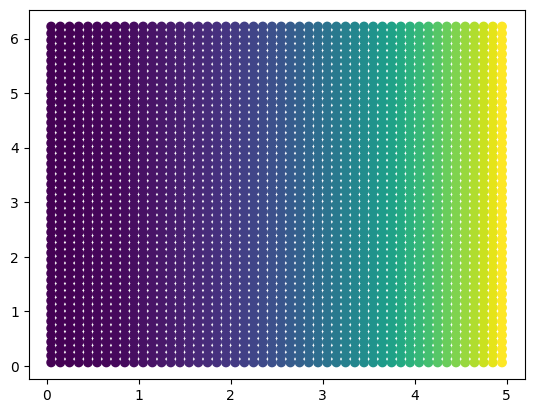

In [4]:
# polar coordinates
from qutree import *
import autograd.numpy as np
from functools import partial

def polar(q):
    r = q[0]
    phi = q[1]
    x1 = r*np.cos(phi)
    x2 = r*np.sin(phi)
    return np.array([x1, x2])

def vol(q):
    J = jacobian(polar)
    return np.linalg.det(J(q).T @ J(q))

N = 50
q1 = Grid(linspace(0, 5, N), [0])
q2 = Grid(linspace(0, 2*np.pi, N), [1])
g = q1 @ q2
g = g.permute()
V = g.evaluate(vol)
# Create the 3D surface plot
X = g.grid[:, 0]
Y = g.grid[:, 1]
plt.scatter(g.grid[:, 0], g.grid[:, 1], c=V, cmap='viridis')



In [5]:
# spherical coordinates
# Define the vector-valued function x(q)
def x(q):
    r = q[0]
    theta = q[1]
    phi = q[2]
    x1 = r*np.sin(theta)*np.cos(phi)
    x2 = r*np.sin(theta)*np.sin(phi)
    x3 = r*np.cos(theta)
    return np.array([x1, x2, x3])

# Calculate the derivative of x(q) using autograd
J = jacobian(x)

def detJ_spherical(q):
    G = J(q).T @ J(q)
    g = np.sqrt(np.linalg.det(G))
    return g

print("Derivative of x(q) with respect to q:")
q = np.array([3., np.pi*0.5, np.pi*1.])
print(detJ_spherical(q))

Derivative of x(q) with respect to q:
9.000000000000002


In [6]:
from qutree import *
import autograd.numpy as np
from autograd import jacobian
import plotly.graph_objects as go
N = 10
q1 = Grid(linspace(0, 5, N), [0])
q2 = Grid(linspace(0, np.pi, N), [1])
q3 = Grid(linspace(0, 2*np.pi, N), [2])
q123 = q1 @ q2 @ q3
Fref = q123.evaluate(detJ_spherical)
#x123 = q123.evaluate(x)
#fig = go.Figure(data=[go.Scatter3d(x=q123.grid[:, 0], y=q123.grid[:, 1], z=q123.grid[:, 2], mode='markers', marker=dict(size=5, color=F, colorscale='Viridis', opacity=0.8))])
#fig = go.Figure(data=[go.Scatter3d(x=x123[:, 0], y=x123[:, 1], z=x123[:, 2], mode='markers', marker=dict(size=5, color=F, colorscale='Viridis', opacity=0.8))])
#fig.show()

In [7]:
r = 1
N = 10
O = Objective(detJ_spherical, [linspace(0, 5, N), linspace(0, np.pi, N), linspace(0, 2*np.pi, N)])
G = balanced_tree(3, r, N)
G = tn_grid(G, O.linspace)
Gopt, df = ttnopt(G, O, nsweep = 5)
fig = grid_animation(df)

F = extract_root_tensor(contract(Gopt))
print('Error: ', np.linalg.norm(F - Fref) / np.linalg.norm(Fref))


Error:  3.266578359908875e-16


In [8]:
from qutree import *
import autograd.numpy as np
from autograd import jacobian
from functools import partial

def x(q):
    r = q[0]
    theta = q[1]
    phi = q[2]
    x1 = r*np.sin(theta)*np.cos(phi)
    x2 = r*np.sin(theta)*np.sin(phi)
    x3 = r*np.cos(theta)
    return np.array([x1, x2, x3])

# Calculate the derivative of x(q) using autograd

def T_ij(q, i, j, x):
    J = jacobian(x)
    G = J(q).T @ J(q)
    g = np.sqrt(np.linalg.det(G))
    return G[i, j] * g

# compression of element with tn
r = 1
N = 10
i = 0
j = 0

# for an element
T = partial(T_ij, i = i, j = j, x = x)
O = Objective(T, [linspace(0, 5, N), linspace(0, np.pi, N), linspace(0, 2*np.pi, N)])
G = balanced_tree(3, r, N)
G = tn_grid(G, O.linspace)
Gopt, df = ttnopt(G, O, nsweep = 5)
fig = grid_animation(df)
F = tn_to_tensor(Gopt)

q1 = Grid(linspace(0, 5, N), [0])
q2 = Grid(linspace(0, np.pi, N), [1])
q3 = Grid(linspace(0, 2*np.pi, N), [2])
q123 = q1 @ q2 @ q3
Fref = q123.evaluate(O.Err)
print('rel Error: ', np.linalg.norm(F - Fref) / np.linalg.norm(Fref+1e-1))
print('abs Error / Ngrid: ', np.linalg.norm(F - Fref) / N**3)
print(np.max(np.abs(F)))
print(np.max(np.abs(Fref)))

x123 = q123.evaluate(x)
fig = go.Figure(data=[go.Scatter3d(x=q123.grid[:, 0], y=q123.grid[:, 1], z=q123.grid[:, 2], mode='markers', marker=dict(size=5, color=F, colorscale='Viridis', opacity=0.8))])
#fig = go.Figure(data=[go.Scatter3d(x=x123[:, 0], y=x123[:, 1], z=x123[:, 2], mode='markers', marker=dict(size=5, color=Fref, colorscale='Viridis', opacity=0.8))])
fig.show()

rel Error:  3.401894808055507e-16
abs Error / Ngrid:  8.542267158737455e-17
22.2847181846778
22.2847181846778


In [11]:
import numpy as np

def evaluate_S1(Xv):
    mN = 25529.
    muv = 1./13615.5
    mud = 1./29456.5
    smud = np.sqrt(1. / mud)
    xd = Xv[1] / smud
    rd = 1. - np.exp(-1.5 * (xd - 4.315))
    rv = Xv[0] / np.sqrt(1. / muv) - 2.136
    pi = 3.14159265359
    a = np.exp(-1.1 * Xv[2]) - np.exp(-1.1 * np.cos(np.pi * 127.4 / 180))

    v = 0.6816 * rv ** 2 - 0.9123 * rv ** 3 + 0.4115 * rv ** 4 + (
        (0.0384816 + 0.0247875 * a + 0.0270933 * a ** 2 + 0.00126791 * a ** 3 +
         0.00541285 * a ** 4 + 0.0313629 * a ** 5 + 0.0172449 * a ** 6) +
        (0.00834237 + 0.00398713 * a + 0.00783319 * a ** 2 + 0.0294887 * a ** 3 -
         0.0154387 * a ** 4 - 0.0621984 * a ** 5 - 0.0337951 * a ** 6) * rd +
        (0.00161625 - 0.000156328 * a - 0.0189982 * a ** 2 - 0.00753297 * a ** 3 +
         0.00383665 * a ** 4 - 0.00758225 * a ** 5 - 0.00904493 * a ** 6) * rd ** 2 +
        (-0.00101009 + 0.000619148 * a - 0.0149812 * a ** 2 - 0.0199722 * a ** 3 +
         0.00873013 * a ** 4 + 0.0376118 * a ** 5 + 0.0221523 * a ** 6) * rd ** 3 +
        (-0.000368904 + 0.000164037 * a - 0.00331809 * a ** 2 - 0.00567787 * a ** 3 +
         0.00268662 * a ** 4 + 0.0134483 * a ** 5 + 0.0084585 * a ** 6) * rd ** 4 +
        (-0.0558666 - 0.0276576 * a + 0.0934932 * a ** 2 - 0.0295638 * a ** 3 -
         0.15436 * a ** 4 + 0.0796119 * a ** 5 + 0.135121 * a ** 6 +
         (0.0582169 + 0.0384404 * a + 0.078114 * a ** 2 + 0.185556 * a ** 3 -
          0.0641656 * a ** 4 - 0.175976 * a ** 5 - 0.0104994 * a ** 6) * rd +
         (0.052285 + 0.0472724 * a - 0.216008 * a ** 2 - 0.147775 * a ** 3 +
          0.349283 * a ** 4 + 0.28458 * a ** 5 + 0.00384449 * a ** 6) * rd ** 2 +
         (0.0212609 + 0.0290597 * a - 0.109124 * a ** 2 + 0.0310445 * a ** 3 +
          0.262513 * a ** 4 - 0.250653 * a ** 5 - 0.369466 * a ** 6) * rd ** 3 +
         (0.00334178 + 0.0039061 * a - 0.0110452 * a ** 2 + 0.0582029 * a ** 3 +
          0.0679524 * a ** 4 - 0.16459 * a ** 5 - 0.165337 * a ** 6) * rd ** 4) * rv +
        (-0.163186 - 0.180535 * a + 0.04692 * a ** 2 + 0.471673 * a ** 3 +
         0.403267 * a ** 4 - 0.718071 * a ** 5 - 0.761199 * a ** 6 +
         (-0.0290674 - 0.0136172 * a - 0.108952 * a ** 2 - 1.68269 * a ** 3 -
          1.2673 * a ** 4 + 3.17648 * a ** 5 + 2.92793 * a ** 6) * rd +
         (0.121228 + 0.202308 * a + 0.483613 * a ** 2 + 1.29095 * a ** 3 -
          0.174483 * a ** 4 - 2.4605 * a ** 5 - 1.36597 * a ** 6) * rd ** 2 +
         (0.107233 + 0.115213 * a - 0.366102 * a ** 2 + 0.812662 * a ** 3 +
          1.76038 * a ** 4 - 1.19665 * a ** 5 - 1.77392 * a ** 6) * rd ** 3 +
         (0.0232767 + 0.0304932 * a - 0.19455 * a ** 2 - 0.0307517 * a ** 3 +
          0.539365 * a ** 4 + 0.120203 * a ** 5 - 0.251289 * a ** 6) * rd ** 4) * rv ** 2 +
        (0.0838975 + 0.198853 * a - 0.0994766 * a ** 2 - 0.822409 * a ** 3 -
         0.586006 * a ** 4 + 1.17402 * a ** 5 + 1.17378 * a ** 6 +
         (-0.182047 - 0.245637 * a + 0.130396 * a ** 2 + 2.85439 * a ** 3 +
          2.44277 * a ** 4 - 5.36406 * a ** 5 - 5.22806 * a ** 6) * rd +
         (-0.227493 - 0.470604 * a - 0.670555 * a ** 2 - 1.66997 * a ** 3 +
          0.268677 * a ** 4 + 3.71822 * a ** 5 + 2.10678 * a ** 6) * rd ** 2 +
         (-0.13635 - 0.193843 * a + 0.626076 * a ** 2 - 1.55192 * a ** 3 -
          3.22512 * a ** 4 + 3.03851 * a ** 5 + 4.01364 * a ** 6) * rd ** 3 +
         (-0.0262554 - 0.0391291 * a + 0.312858 * a ** 2 - 0.122063 * a ** 3 -
          1.03112 * a ** 4 + 0.28978 * a ** 5 + 0.878604 * a ** 6) * rd ** 4) * rv ** 3) * (1. - rd)
    v = max(-0.1, v)

    return min(5., v) + 3.

# Example usage:
Xv = np.array([251., 740.0, 2.22])
result = evaluate_S1(Xv)
print(result - 3) # check if I shifted by 3 or so


0.19866374625670513


In [12]:

def p(q):
    a = (0.008, 0.0027, 90.)
    q0 = (251., 740., 2.22)
    p0 = np.exp(-0.25*a[0]*(q[0]-q0[0])**2)
    p1 = np.exp(-0.25*a[1]*(q[1]-q0[1])**2)
    p2 = np.exp(-0.25*a[2]*(q[2]-q0[2])**2)
    return p0*p1*p2# + eps

def Vw(q):
    return evaluate_S1(q) * p(q)

V = Vw
N = 20
O = Objective(V, [linspace(200, 300, N), linspace(550, 1200, N), linspace(0, np.pi, N)])
G = balanced_tree(3, r = 4, N = N)
G = tn_grid(G, O.linspace)
Gopt, df = ttnopt(G, O, nsweep = 5)
fig = grid_animation(df)
#F = tn_to_tensor(Gopt)
fig.show()